In [1]:
!pip install qulacs
!pip install qulacsvis
!pip install matplotlib
!pip install numpy
!pip install scipy

     |████████████████████████████████| 3.1 MB 18.3 MB/s eta 0:00:01
     |████████████████████████████████| 9.4 MB 81.4 MB/s eta 0:00:01
     |████████████████████████████████| 48 kB 222 kB/s  eta 0:00:01
     |████████████████████████████████| 295 kB 136.8 MB/s eta 0:00:01
     |████████████████████████████████| 965 kB 91.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 146.5 MB/s eta 0:00:01
  Created wheel for temp: filename=temp-2020.7.2-py3-none-any.whl size=1293 sha256=a3c2d3928408ee842a965edcd9a0958b18313f29e0789ccd29444b0b62ee7e77
  Stored in directory: /home/sakaue/.cache/pip/wheels/a4/21/b9/b8c88d91e9c320c6bebc35a3536ed33774a6a2cea0b2137016
Successfully built temp


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime as dt
import random
import math
from qulacs import QuantumState, Observable, QuantumCircuit
from qulacsvis import circuit_drawer
from qulacs.circuit import QuantumCircuitOptimizer
from qulacs.state import inner_product
import scipy.optimize
from qulacs.gate import Identity, X,Y,Z
from qulacs.gate import H,S,Sdag,T,Tdag,sqrtX,sqrtXdag,sqrtY,sqrtYdag
from qulacs.gate import RX,RY,RZ,CNOT, CZ, SWAP
from qulacs.gate import to_matrix_gate,RandomUnitary,DenseMatrix,merge
from scipy import stats
from scipy.integrate import quad

# Appendix Bの量子回路を用いたAlgorithm1の実装

-----

## トロッター分解

1次元横磁場イジング模型におけるハミルトニアン
$$\bar{H} = -(2-\lambda)\sum_{i=0}^{3}Z_iZ_{i+1} -\lambda\sum_{i=0}^3X_i\equiv -\alpha\sum_{i=0}^{3}Z_iZ_{i+1}-\beta\sum_{i=0}^3X_i=\sum_{i=1}^6a_i O_i$$
を考える。ここで、$\alpha\equiv2-\lambda,\beta\equiv\lambda$とした。

トロッター分解
$$e^{-i\bar{H}t}=\left(e^{i\{\alpha(Z_0Z_1+Z_1Z_2+Z_2Z_3+Z_3Z_1)+\beta(X_0+X_1+X_2+X_3)\}\frac{t}{M}}\right)^M\approx\left(e^{i\alpha(Z_0Z_1)\frac{t}{M}}\cdot\cdots\cdot e^{i\beta(X_3)\frac{t}{M}}\right)^M=\left(e^{i\alpha(Z_0Z_1)\delta}\cdot\cdots\cdot e^{i\beta(X_3)\delta}\right)^M$$
を用いて、実時間発展演算子を量子回路に実装する。ここで、$\delta\equiv\frac{t}{M}$とした。

分解した実時間発展が
$$e^{i\alpha\delta Z_iZ_{i+1}}=CX_{i,i+1}e^{i\alpha\delta Z_{i+1}}CX_{i,i+1}=CX_{i,i+1}RZ_{i+1}\left(2\alpha\delta\right)CX_{i,i+1}$$
のように量子回路で表現できることを用いて実装していく。(CX：制御NOTゲート、RZ：PauliZ回転ゲート)

量子回路で求める期待値は、物理量の各項の係数の合計を$a_{total}=\sum\limits_{i=1}^6|a_i|$としたとき、
その割合$\left\{\frac{|a_i|}{a_{total}},\cdots,\frac{|a_6|}{a_{total}}\right\}$に従ってNs回$O_i$をサンプルして、期待値
$$\left<\bar{H}\right>\approx\frac{1}{N_s}\sum\limits_{j}^{N_s}\left<O_j\right>$$
を求める。(ただし、係数は正確に記述していない。)

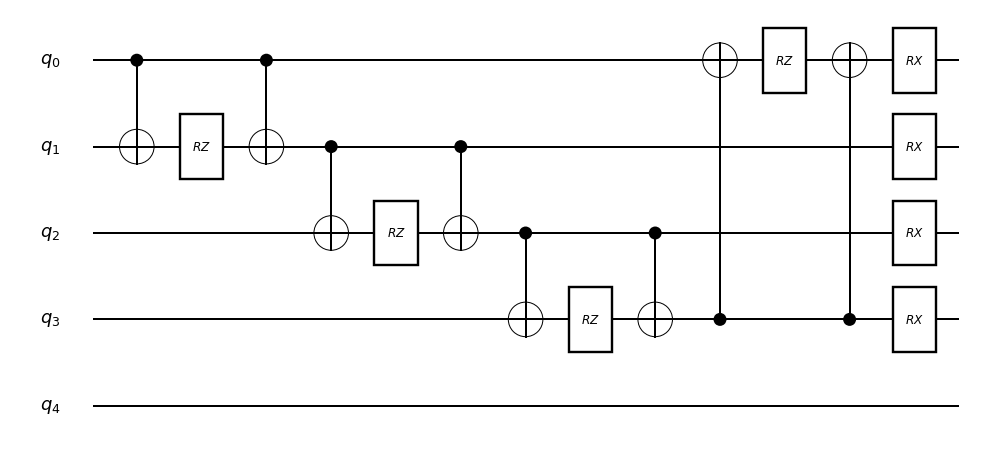

In [3]:
# number of qubits without an ancillary qubit.
n_qubits = 4
# number of all qubits.
nqubits = n_qubits + 1
state = QuantumState(nqubits)
state.set_zero_state()

# time to simulate
t_1 = 1.0 # t
t_2 = 1.0 # t'
# trotter step
M = 1
# trotter stride
δ = t_1/M ################################## check before you execute
# parameter
λ = 1


circuit_trotter_Ising = QuantumCircuit(nqubits)
for i in range(M):
    for i in range(nqubits-1):
        circuit_trotter_Ising.add_CNOT_gate(i,(i+1)%(nqubits-1))
        circuit_trotter_Ising.add_RZ_gate((i+1)%(nqubits-1),-2*(2-λ)*δ) # exp(i*α*δ*Z)=RZ(2*α*δ) => in qulacs => RZ(-2*α*δ)
        circuit_trotter_Ising.add_CNOT_gate(i,(i+1)%(nqubits-1))
    for i in range(nqubits-1):
        circuit_trotter_Ising.add_RX_gate((i%(nqubits-1)),-2*λ*δ) # exp(i*β*δ*X)=RX(2*β*δ) => in qulacs => RX(-2*β*δ)
circuit_drawer(circuit_trotter_Ising,"mpl")

-----

## $t$を確率密度関数$g\left(t\right)=\frac{1}{\pi}\frac{\beta}{\beta^2+t^2}\exp(-\frac{\beta^2+t^2}{2\tau^2})$に従って棄却サンプリングする

In [4]:
# imports
import warnings
warnings.filterwarnings('ignore')
import os, sys
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy as sp
from scipy.constants import pi



目標分布：$g(t)=\frac{1}{\pi}\frac{\beta}{\beta^2+t^2}\exp(-\frac{\beta^2+t^2}{2\tau^2})$

提案分布 : $q(t)=g(0)$

In [5]:
# target pdf g(t)
def g(t,β=1,τ=10):
    return 1/np.pi*β/(β**2+t**2)*np.exp(-(β**2+t**2)/2*τ**2)

# done

In [6]:
g(1, 1, 10)

5.920684802611233e-45

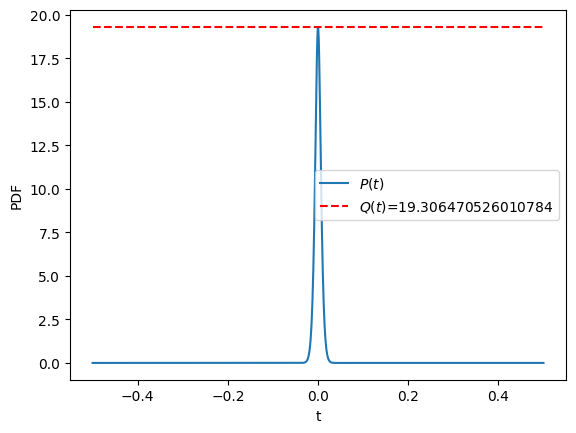

In [196]:
β=0.01
τ=100
tmax = 0.5
tmin = -1*tmax
x = np.linspace(tmin,tmax,10**3)
P = g(x,β,τ)
Q = g(0,β,τ)
plt.plot(x,P,label="$P(t)$")
plt.plot([tmin, tmax],[Q, Q], "red", linestyle='dashed',label=f'$Q(t)$={Q}')
plt.xlabel("t")
plt.ylabel('PDF')
plt.legend()
plt.show()



In [6]:
# rejection sampling
def sampling(tmin=-0.5,tmax=0.5,β=1,τ=10):
    # maximum value of g(t)
    k = g(0,β,τ)
    while True:
        # sample from the proposed distribution [min_range,max_range)
        t = np.random.uniform(tmin,tmax)
        # sample u from [0,k)
        u = k*np.random.uniform(0,1.0)
        # judge if accept
        if g(t,β,τ) > u:
            return t
        
#done
        

In [197]:
β=0.01
τ=100
tmax = 0.05
tmin = -1*tmax
x = np.linspace(tmin,tmax,10**4)
y = g(x,β,τ)



In [198]:
# get sample
N = 10**7
# time measure
t_mes_0 = dt.datetime.now()
# sampling using rejection sampling
samples = np.array([sampling(tmin,tmax,β,τ) for i in range(N)])
# time measure
t_mes_1 = dt.datetime.now()
print('Elapsed Time: ', t_mes_1- t_mes_0)



Elapsed Time:  0:13:29.155308


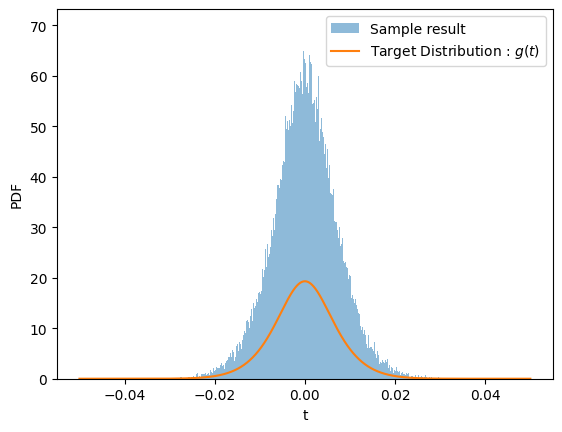

In [199]:
# plot
%matplotlib inline
plt.hist(samples, bins = 10**5, density = True, alpha = 0.5, label = 'Sample result')
plt.plot(x,y, label = 'Target Distribution : $g(t)$')
plt.xlabel("t")
plt.ylabel('PDF')
plt.legend()
plt.show()


In [200]:
β=0.01
τ=100
tmax = 0.05
tmin = -1*tmax
x = np.linspace(tmin,tmax,10**4)
y = g(x,β,τ)


In [ ]:
# get sample
N = 10**8
# time measure
t_mes_0 = dt.datetime.now()
# sampling using rejection sampling
samples = np.array([sampling(tmin,tmax,β,τ) for i in range(N)])
# time measure
t_mes_1 = dt.datetime.now()
print('Elapsed Time: ', t_mes_1- t_mes_0)


In [ ]:
# plot
%matplotlib inline
plt.hist(samples, bins = 10*6, density = True, alpha = 0.5, label = 'Sample result')
plt.plot(x,y, label = 'Target Distribution : $g(t)$')
plt.xlabel("t")
plt.ylabel('PDF')
plt.legend()
plt.show()

In [148]:
# practice
from scipy import stats
import math
N=1000
class gaussian(stats.rv_continuous):

    def _pdf(self, x, mu, sigma):
        normalize_factor = 1.0/(2.0*math.pi*sigma**2)**(1/2)
        px = normalize_factor * math.exp(-(x-mu)**2/(2*sigma**2))

        return px

gaussian = gaussian(name="gaussian", a=0.0)    
sample_from_gaussian = gaussian.rvs(size=N, mu=10.0, sigma=1.0) 



10.072257876020188
0.9806885879945281


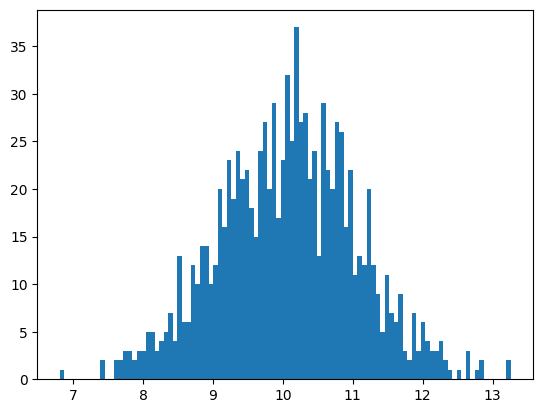

In [14]:
# practice
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(sample_from_gaussian,bins=100)
print(np.mean(sample_from_gaussian))
print(np.var(sample_from_gaussian))
fig.show()



In [15]:
# practice
t = np.random.uniform(-100,100,1000000)



0.08403876850719576
3336.907424953073


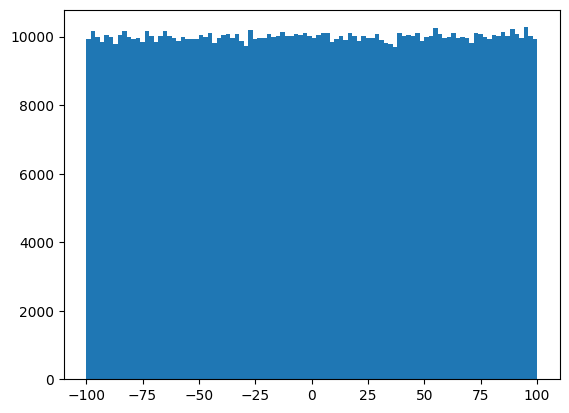

In [16]:
# practice
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(t,bins=100)
print(np.mean(t))
print(np.var(t))
fig.show()



---

### Qulacsでのサンプル結果の意味を実装により確認する。

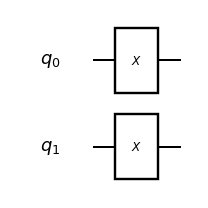

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
0b11


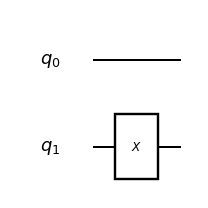

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0b10


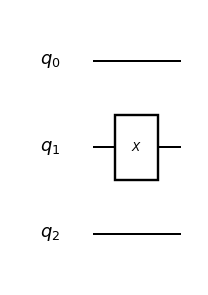

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
0b10


In [17]:
"""
    Check arrangements of sampling result of qulacs.
"""

example_nqubits = 2
example_state = QuantumState(example_nqubits)
example_state.set_zero_state()
example_circuit = QuantumCircuit(example_nqubits)
example_circuit.add_X_gate(0)
example_circuit.add_X_gate(1)
circuit_drawer(example_circuit,"mpl")
example_circuit.update_quantum_state(example_state)
a = example_state.sampling(10)
print(a)
print(bin(a[0]))


example_nqubits = 2
example_state = QuantumState(example_nqubits)
example_state.set_zero_state()
example_circuit = QuantumCircuit(example_nqubits)
example_circuit.add_X_gate(1)
circuit_drawer(example_circuit,"mpl")
example_circuit.update_quantum_state(example_state)
a = example_state.sampling(10)
print(a)
print(bin(a[0]))


example_nqubits = 3
example_state = QuantumState(example_nqubits)
example_state.set_zero_state()
example_circuit = QuantumCircuit(example_nqubits)
example_circuit.add_X_gate(1)
circuit_drawer(example_circuit,"mpl")
example_circuit.update_quantum_state(example_state)
a = example_state.sampling(10)
print(a)
print(bin(a[0]))

|(1th) (0th)>

-----

### トロッター分解をした横磁場イジングモデルの実時間発展演算子を量子回路に実装する。

In [7]:
"""
    Add Trotterised RTS operator to quantum circuit.
"""
def trotter_Ising_circuit_drawer(t,δ,λ,nqubits,circuit):
    M = int(t/δ)
    Vt_i_gate = Identity(0)
    for i in range(M):
        for i in range(nqubits-1):
            Vt_i_gate = merge(Vt_i_gate,CNOT(i,(i+1)%(nqubits-1)))
            Vt_i_gate = merge(Vt_i_gate,RZ((i+1)%(nqubits-1),-2*(2-λ)*δ)) # exp(i*α*δ*Z)=RZ(2*α*δ) => in qulacs => RZ(-2*α*δ)
            Vt_i_gate = merge(Vt_i_gate,CNOT(i,(i+1)%(nqubits-1)))
        for i in range(nqubits-1):
            Vt_i_gate = merge(Vt_i_gate,RX(i%(nqubits-1),-2*λ*δ))  # exp(i*β*δ*X)=RX(2*β*δ) => in qulacs => RX(-2*β*δ)
    Vt_i_mat_gate = to_matrix_gate(Vt_i_gate)
    control_index = nqubits-1
    control_with_value = 1
    Vt_i_mat_gate.add_control_qubit(control_index,control_with_value)
    circuit.add_gate(Vt_i_mat_gate)

# done
    

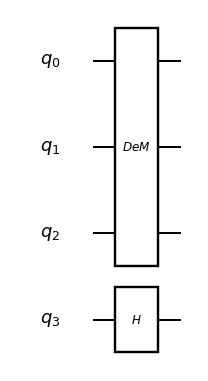

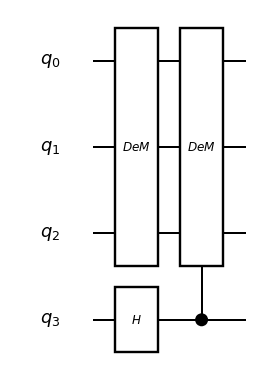

In [45]:
"""
    Check if the function "trotter_Ising_circuit_drawer" is working.
"""
nqubits = 4
circuit_practice_1 = QuantumCircuit(nqubits)
circuit_practice_1.add_H_gate(nqubits-1)
target_list = [i for i in range(nqubits-1)]
random_unitary_gate = RandomUnitary(target_list)
circuit_practice_1.add_gate(random_unitary_gate)
circuit_drawer(circuit_practice_1,"mpl")

t = 1.0
δ = 0.1
λ = 1.0
trotter_Ising_circuit_drawer(t,δ,λ,nqubits,circuit_practice_1)
circuit_drawer(circuit_practice_1,"mpl")



---

### $\left\{\frac{|a_1|}{a_{total}},\cdots,\frac{|a_6|}{a_{total}}\right\}$に従ってNs回$O_i$をサンプルする。

In [8]:
"""
    Select observable Oi from O = ΣaiOi by sampling according to its distribution |aj|/aO.
"""
def select_obs_Ising(nqubits, coef_1, coef_2, Ns):
    coef_total = (nqubits-1)*abs(coef_1+coef_2)
    obs_list_total = [0 for i in range((nqubits-1)*2)] # list => numpy.zeros dtypeに注意
    prob_list_total = [0 for i in range((nqubits-1)*2)]
    selection_list = [i for i in range((nqubits-1)*2)]
    for i in range((nqubits-1)):
        obs_list_total[i] = [3,i,coef_1]
        obs_list_total[i+(nqubits-1)] = [1,i,coef_2]
        prob_list_total[i] = abs(coef_1)/coef_total
        prob_list_total[i+(nqubits-1)] = abs(coef_2)/coef_total
    
    rng = np.random.default_rng()
    res_index = rng.choice(selection_list, Ns, p=prob_list_total)
    sampled_obs_list = []
    for index in res_index:
        sampled_obs_list.append(obs_list_total[index])
        
    return coef_total,sampled_obs_list # [gate,index,coefficient]

# done


In [60]:
"""
    Check if the function "select_obs_Ising" is working correctly.
"""
nqubits = 4
coef_1 = 2.0 # α
coef_2 = 3.0 # β
Ns = 20
select_obs_Ising(nqubits,coef_1,coef_2,Ns)

(15.0,
 [[3, 0, 2.0],
  [1, 1, 3.0],
  [1, 2, 3.0],
  [1, 1, 3.0],
  [3, 2, 2.0],
  [1, 2, 3.0],
  [3, 1, 2.0],
  [1, 0, 3.0],
  [1, 1, 3.0],
  [1, 0, 3.0],
  [1, 2, 3.0],
  [3, 1, 2.0],
  [3, 2, 2.0],
  [3, 1, 2.0],
  [1, 1, 3.0],
  [1, 1, 3.0],
  [1, 1, 3.0],
  [1, 2, 3.0],
  [1, 0, 3.0],
  [1, 1, 3.0]])

for文を用いた0のlistとnumpy.zerosの速さ比較

In [22]:
t_start = dt.datetime.now()
a = np.zeros(10**5)
t_end = dt.datetime.now()
t_numpy = t_end - t_start
print(t_numpy)
t_start = dt.datetime.now()
a = [0 for i in range(10**5)]
t_end = dt.datetime.now()
t_for = t_end - t_start
print(t_for)
print("Difference of [t_for - t_numpy] = ", t_for - t_numpy)



0:00:00.000382
0:00:00.003606
Difference of [t_for - t_numpy] =  0:00:00.003224


---

### Controlled-$O_i$を量子回路に実装する。

In [9]:
"""
    Add controlled selected observable Oi to quantum circuit.
"""
def observable_circuit_drawer(δ,λ,nqubits,circuit,sampled_Obs):
    index = sampled_Obs[1]
    gate = sampled_Obs[0]
    Obs_gate = Identity(index)
    if gate == 3:
        Obs_gate = merge(Obs_gate,Z(index))
        Obs_gate = merge(Obs_gate,Z((index+1)%(nqubits-1)))
        Obs_mat_gate = to_matrix_gate(Obs_gate)
    else:
        Obs_gate = merge(Obs_gate,X(index))
        Obs_mat_gate = to_matrix_gate(Obs_gate)
    control_index = nqubits-1
    control_with_value = 1
    Obs_mat_gate.add_control_qubit(control_index,control_with_value)
    circuit.add_gate(Obs_mat_gate)
    
    
    

In [33]:
a = np.array([1, 5, 12, 0, 5, 1])

In [35]:
np.put(a, 5, 500)

In [36]:
a

array([  1,   5,  12,   0,   5, 500])

In [30]:
"""
    Check the function of "merge".
"""
nqubits = 2
state = QuantumState(nqubits)
state.set_zero_state()
a = Identity(0)
b = X(1)
c = merge(a,b)
c.update_quantum_state(state)
print(bin(state.sampling(1)[0]))


nqubits = 2
state = QuantumState(nqubits)
state.set_zero_state()
a = Identity(0)
b = X(1)
c = merge(a,b)
d = X(0)
e = merge(c,d)
e.update_quantum_state(state)
print(bin(state.sampling(1)[0]))



0b10
0b11


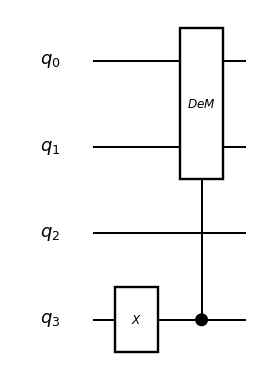

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
0b1000


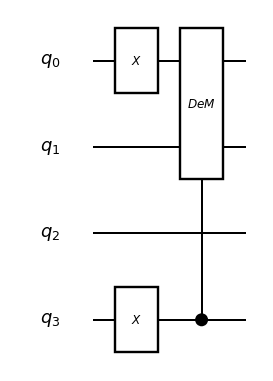

[9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
0b1001


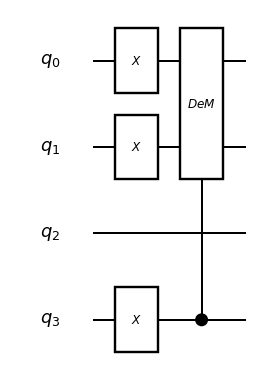

[11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
0b1011


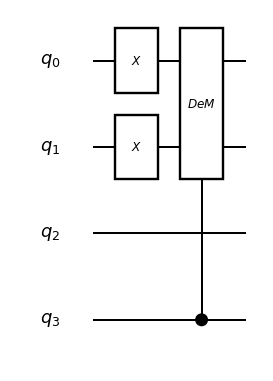

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
0b11


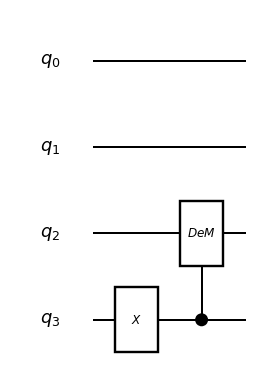

[12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
0b1100


In [46]:
"""
    Check if the function "observable_circuit_drawer" is working correctly.
"""
δ = 0.1
λ = 1.0
nqubits = 4
circuit = QuantumCircuit(nqubits)
circuit.add_X_gate(nqubits-1)
sampled_Obs = [3, 0, 3.0] # [gate,index,coefficient] => Z_0Z_1
observable_circuit_drawer(δ,λ,nqubits,circuit,sampled_Obs)
circuit_drawer(circuit,"mpl")

state = QuantumState(nqubits)
state.set_zero_state()
circuit.update_quantum_state(state)
res_sampling = state.sampling(10)
print(res_sampling)
print(bin(res_sampling[0]))



δ = 0.1
λ = 1.0
nqubits = 4
circuit = QuantumCircuit(nqubits)
circuit.add_X_gate(nqubits-1)
circuit.add_X_gate(0)
sampled_Obs = [3, 0, 3.0] # [gate,index,coefficient] => Z_0Z_1
observable_circuit_drawer(δ,λ,nqubits,circuit,sampled_Obs)
circuit_drawer(circuit,"mpl")

state = QuantumState(nqubits)
state.set_zero_state()
circuit.update_quantum_state(state)
res_sampling = state.sampling(10)
print(res_sampling)
print(bin(res_sampling[0]))



δ = 0.1
λ = 1.0
nqubits = 4
circuit = QuantumCircuit(nqubits)
circuit.add_X_gate(nqubits-1)
circuit.add_X_gate(0)
circuit.add_X_gate(1)
sampled_Obs = [3, 0, 3.0] # [gate,index,coefficient] => Z_0Z_1
observable_circuit_drawer(δ,λ,nqubits,circuit,sampled_Obs)
circuit_drawer(circuit,"mpl")

state = QuantumState(nqubits)
state.set_zero_state()
circuit.update_quantum_state(state)
res_sampling = state.sampling(10)
print(res_sampling)
print(bin(res_sampling[0]))



δ = 0.1
λ = 1.0
nqubits = 4
circuit = QuantumCircuit(nqubits)
circuit.add_X_gate(0)
circuit.add_X_gate(1)
sampled_Obs = [3, 0, 3.0] # [gate,index,coefficient] => Z_0Z_1
observable_circuit_drawer(δ,λ,nqubits,circuit,sampled_Obs)
circuit_drawer(circuit,"mpl")

state = QuantumState(nqubits)
state.set_zero_state()
circuit.update_quantum_state(state)
res_sampling = state.sampling(10)
print(res_sampling)
print(bin(res_sampling[0]))



δ = 0.1
λ = 1.0
nqubits = 4
circuit = QuantumCircuit(nqubits)
circuit.add_X_gate(nqubits-1)
sampled_Obs = [1, 2, 3.0] # [gate,index,coefficient] => X_0
observable_circuit_drawer(δ,λ,nqubits,circuit,sampled_Obs)
circuit_drawer(circuit,"mpl")

state = QuantumState(nqubits)
state.set_zero_state()
circuit.update_quantum_state(state)
res_sampling = state.sampling(10)
print(res_sampling)
print(bin(res_sampling[0]))



### 補助量子ビットの結果だけをMs回サンプルした結果から抽出する。

In [10]:
"""
    Extract only an ancillary qubit's result from Ms sampled result.
"""
def extract_result(samples,nqubits):
    length = len(samples)
    res = []
    for sample in samples:
        bin_result = list(bin(sample))[2:]
        # print("bin_result : ",bin_result)
        require_num_0 = nqubits-len(bin_result)
        fixed_bin_result = [0 for i in range(require_num_0)] + bin_result
        # print("fixed_bin_result : ",fixed_bin_result)
        res.append(int(fixed_bin_result[0]))
    print(res)
    return res

In [27]:
"""
    Check if the function "extract_result" is working correctly.
"""
samples = [0b110,0b1,0b1000]
nqubits = 4
extract_result(samples,nqubits)

[0, 0, 1]


[0, 0, 1]

### 実装

Sampling preparation finished.


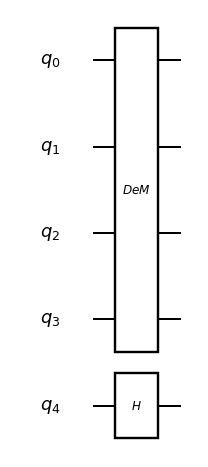

In [12]:
# number of qubits without an ancillary qubit.
n_qubits = 4
# number of all qubits.
nqubits = n_qubits + 1 #  nqubits => _ext
state_original = QuantumState(nqubits)
state_original.set_zero_state()

# trotter stride
δ = 0.1
# parameter
λ = 1
E_0 = 0
β=0.01
τ=10
# number of random sampling (t,t')
Ns = 10**1
# number of circuit shots
Ms = 10**1
# range of (t,t')
tmax = 0.5
tmin = -1*tmax
# time to simulate
t_1s = np.array([sampling(tmin,tmax,β,τ) for i in range(Ns)]) # ts
t_2s = np.array([sampling(tmin,tmax,β,τ) for i in range(Ns)]) # t's
print("Sampling preparation finished.")
# Select observable Oi from O = ΣaiOi by sampling according to its distribution |aj|/aO and add to quantum circuit.
aO,sampled_Obs = select_obs_Ising(nqubits,-1*(2-λ),-1*λ,Ns)
# print(sampled_Obs) => [[gate,index,coefficient],...]
# print(aO) => aO=Σai

# prepare initial state (U_i tensor H)(|Ψ> tensor |0>)
circuit_trotter_Ising_original = QuantumCircuit(nqubits)
circuit_trotter_Ising_original.add_H_gate(nqubits-1)
target_list = [i for i in range(nqubits-1)] ####### numpyでも良い？
random_unitary_gate = RandomUnitary(target_list)
circuit_trotter_Ising_original.add_gate(random_unitary_gate)

circuit_drawer(circuit_trotter_Ising_original,"mpl")




## X測定

In [48]:
# time measure
t_start = dt.datetime.now()

res_X_sampling = np.array([])
count_t_1 = 0
for t_1 in t_1s:
    t_start_i = dt.datetime.now()
    count_t_1 += 1
    for t_2 in t_2s:
        # prepare trotter part
        circuit_trotter_Ising_original_copy = circuit_trotter_Ising_original.copy()
        trotter_Ising_circuit_drawer(t_1,δ,λ,nqubits,circuit_trotter_Ising_original_copy)
        circuit_trotter_Ising_original_copy.add_X_gate(nqubits-1)
        trotter_Ising_circuit_drawer(t_2,δ,λ,nqubits,circuit_trotter_Ising_original_copy)
        circuit_trotter_Ising_original_copy.add_X_gate(nqubits-1)

        #### circuit_drawer(circuit_trotter_Ising_original_copy,"mpl")

        for obs in sampled_Obs: # => functionにすべき？
            circuit_trotter_Ising = circuit_trotter_Ising_original_copy.copy()
            state = state_original.copy()
            observable_circuit_drawer(δ,λ,nqubits,circuit_trotter_Ising,obs)
            #### circuit_drawer(circuit_trotter_Ising,"mpl")

            # change basis to measure
            circuit_trotter_Ising.add_H_gate(nqubits-1)

            #### circuit_drawer(circuit_trotter_Ising,"mpl")

            circuit_trotter_Ising.update_quantum_state(state)
            samples = state.sampling(Ms) # [2, 5, 12, 98]
            estimated_X = 0
            mask = int("1" + "0"*(nqubits-1),2)
            for s in samples:
                bitcount = bin(s & mask).count("1")
                estimated_X += np.sign(obs[2])*np.exp(E_0*(t_1-t_2))*(-1)**bitcount/Ms

            circuit_trotter_Ising.add_H_gate(nqubits-1)
            res_X_sampling = np.append(res_X_sampling,estimated_X)
    print("count_t_1 = ",count_t_1,f' out of {Ns}.')
    t_end_i = dt.datetime.now()
    print('Elapsed Time_i: ', t_end_i - t_start_i)

print(np.sum(res_X_sampling)*aO/Ns)

# time measure
t_end = dt.datetime.now()
print('Elapsed Time: ', t_end - t_start)

count_t_1 =  1  out of 100.
Elapsed Time_i:  0:00:11.393011


KeyboardInterrupt: 

---

## Y測定

In [41]:
# time measure
t_start = dt.datetime.now()

res_Y_sampling = np.array([])
count_t_1 = 0
for t_1 in t_1s:
    t_start_i = dt.datetime.now()
    count_t_1 += 1
    for t_2 in t_2s:
        # prepare trotter part
        circuit_trotter_Ising_original_copy = circuit_trotter_Ising_original.copy()
        trotter_Ising_circuit_drawer(t_1,δ,λ,nqubits,circuit_trotter_Ising_original_copy)
        circuit_trotter_Ising_original_copy.add_X_gate(nqubits-1)
        trotter_Ising_circuit_drawer(t_2,δ,λ,nqubits,circuit_trotter_Ising_original_copy)
        circuit_trotter_Ising_original_copy.add_X_gate(nqubits-1)

        #### circuit_drawer(circuit_trotter_Ising_original_copy,"mpl")

        for obs in sampled_Obs:
            circuit_trotter_Ising = circuit_trotter_Ising_original_copy.copy()
            state = state_original.copy()
            observable_circuit_drawer(δ,λ,nqubits,circuit_trotter_Ising,obs)
            #### circuit_drawer(circuit_trotter_Ising,"mpl")

            # change basis to measure
            circuit_trotter_Ising.add_Sdag_gate(nqubits-1)
            circuit_trotter_Ising.add_H_gate(nqubits-1)

            #### circuit_drawer(circuit_trotter_Ising,"mpl")

            circuit_trotter_Ising.update_quantum_state(state)
            samples = state.sampling(Ms)
            estimated_Y = 0
            mask = int("1" + "0"*(nqubits-1),2)
            for s in samples:
                bitcount = bin(s & mask).count("1")
                estimated_Y += np.sign(obs[2])*np.exp(E_0*(t_1-t_2))*(-1)**bitcount/Ms

            circuit_trotter_Ising.add_H_gate(nqubits-1)
            circuit_trotter_Ising.add_S_gate(nqubits-1)
            res_Y_sampling = np.append(res_Y_sampling,estimated_Y)
    print("count_t_1 = ",count_t_1,f' out of {Ns}.')
    t_end_i = dt.datetime.now()
    print('Elapsed Time_i: ', t_end_i - t_start_i)
print("result of Y measurement : ",np.sum(res_Y_sampling)*aO/Ns)

# time measure
t_end = dt.datetime.now()
print('Elapsed Time: ', t_end - t_start)

count_t_1 =  1  out of 100.
Elapsed Time_i:  0:00:20.010198
count_t_1 =  2  out of 100.
Elapsed Time_i:  0:00:16.455064
count_t_1 =  3  out of 100.
Elapsed Time_i:  0:00:16.174838
count_t_1 =  4  out of 100.
Elapsed Time_i:  0:00:16.362189
count_t_1 =  5  out of 100.
Elapsed Time_i:  0:00:16.720754
count_t_1 =  6  out of 100.
Elapsed Time_i:  0:00:16.718605
count_t_1 =  7  out of 100.
Elapsed Time_i:  0:00:16.675184
count_t_1 =  8  out of 100.
Elapsed Time_i:  0:00:16.873231
count_t_1 =  9  out of 100.
Elapsed Time_i:  0:00:16.908442
count_t_1 =  10  out of 100.
Elapsed Time_i:  0:00:17.337390
count_t_1 =  11  out of 100.
Elapsed Time_i:  0:00:17.068551
count_t_1 =  12  out of 100.
Elapsed Time_i:  0:00:17.254826
count_t_1 =  13  out of 100.
Elapsed Time_i:  0:00:17.630172
count_t_1 =  14  out of 100.
Elapsed Time_i:  0:00:17.503856
count_t_1 =  15  out of 100.
Elapsed Time_i:  0:00:17.710496
count_t_1 =  16  out of 100.
Elapsed Time_i:  0:00:17.751549
count_t_1 =  17  out of 100.
Elap

In [173]:
a = np.array([])
a = np.append(a,2)
a = np.append(a,3)
a

array([2., 3.])

In [561]:
res = res_X_sampling + res_Y_sampling*1j
res

(4+16j)

In [180]:
state = QuantumState(2)
state.set_zero_state()
a = state.copy()
b = X(0).update_quantum_state(a)
print(state)
print(a)

 *** Quantum State ***
 * Qubit Count : 2
 * Dimension   : 4
 * State vector : 
(1,0)
(0,0)
(0,0)
(0,0)

 *** Quantum State ***
 * Qubit Count : 2
 * Dimension   : 4
 * State vector : 
(0,0)
(1,0)
(0,0)
(0,0)

